<a href="https://colab.research.google.com/github/sk27110/AutoPriceForecast/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

RANDOM_STATE = 42

In [3]:
df = pd.read_csv('processed_data.csv')

In [4]:
df

,price,title,year,mileage,transmission,body_type,drive_type,color,engine_capacity,engine_power,fuel_type,travel_distance
0,189700,Volkswagen Passat B3,1990,325000,механика,универсал 5 дв.,передний,красный,1.8,90.0,Бензин,0
1,370000,Nissan Terrano I,1990,224000,автомат,внедорожник 5 дв.,полный,зелёный,2.7,100.0,Дизель,0
2,350000,Honda Civic IV,1990,200000,механика,седан,передний,серебристый,1.6,120.0,Бензин,0
3,360000,Volkswagen Passat B3,1990,200000,механика,универсал 5 дв.,передний,белый,1.8,90.0,Бензин,0
4,99000,Toyota Carina V (T170),1990,296000,автомат,седан,передний,серебристый,1.5,94.0,Бензин,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199177,15957851,Xiaomi SU7,2024,1,none,седан,полный,жёлтый,0.0,673.0,Электро,800
199178,2082392,Leapmotor C01 90 kWh,2023,20000,none,седан,задний,серебристый,0.0,272.0,Электро,717
199179,11124022,Xiaomi SU7 Ultra,2025,49,none,седан,полный,серый,0.0,1548.0,Электро,630
199180,3220000,Zeekr 001 86 kWh I,2022,35000,none,лифтбек,полный,белый,0.0,544.0,Электро,536


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, shuffle=True)

In [6]:
numerical_cols = ['year', 'mileage', 'engine_capacity', 'engine_power', 'travel_distance']
categorical_cols = ['title', 'transmission', 'body_type', 'drive_type', 'color', 'fuel_type']

In [7]:
current_year = pd.Timestamp.now().year
df['age'] = current_year - df['year']


def clean_mileage(value):
    if pd.isna(value):
        return np.nan

    cleaned = ''.join(filter(str.isdigit, str(value)))
    return float(cleaned) if cleaned else np.nan

df['mileage'] = df['mileage'].apply(clean_mileage)

df['body_style'] = df['body_type'].str.split().str[0]


df['doors'] = df['body_type'].str.extract(r'(\d+)\s?дв').astype(float)


body_door_mapping = {
    'седан': 4,
    'купе': 2,
    'лифтбек': 4,
    'кабриолет': 2,
    'универсал': 5,
    'внедорожник': 5,
    'хэтчбек': 5,
    'минивэн': 5,
    'пикап': 4,
    'фургон': 3
}


for body_style, door_count in body_door_mapping.items():
    mask = df['doors'].isnull() & (df['body_style'] == body_style)
    df.loc[mask, 'doors'] = door_count


df['doors'] = df['doors'].fillna(4)

df = df.drop('body_type', axis=1)



trans_map = {'механика': 0, 'автомат': 1, 'робот': 1, 'вариатор': 1}
df['transmission'] = df['transmission'].map(trans_map).fillna(1)


num_cols = ['mileage', 'engine_capacity', 'engine_power', 'travel_distance', 'age', 'doors']
for col in num_cols:

    df[col].fillna(df[col].median(), inplace=True)


    if col in ['engine_capacity', 'engine_power']:
        df[col] = df[col].replace(0, df[col].median())


cat_cols = ['body_style', 'drive_type', 'color', 'fuel_type']
for col in cat_cols:
    df[col] = df[col].fillna('unknown').astype('category')

df['brand'] = df['title'].str.split().str[0].str.lower().fillna('unknown')

df = df.drop(['title', 'year'], axis=1)

<ipython-input-7-2152393373>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [8]:

X = df.drop('price', axis=1)
y = np.log1p(df['price'])

In [9]:
df

,price,mileage,transmission,drive_type,color,engine_capacity,engine_power,fuel_type,travel_distance,age,body_style,doors,brand
0,189700,325000.0,0.0,передний,красный,1.8,90.0,Бензин,0,35,универсал,5.0,volkswagen
1,370000,224000.0,1.0,полный,зелёный,2.7,100.0,Дизель,0,35,внедорожник,5.0,nissan
2,350000,200000.0,0.0,передний,серебристый,1.6,120.0,Бензин,0,35,седан,4.0,honda
3,360000,200000.0,0.0,передний,белый,1.8,90.0,Бензин,0,35,универсал,5.0,volkswagen
4,99000,296000.0,1.0,передний,серебристый,1.5,94.0,Бензин,0,35,седан,4.0,toyota
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199177,15957851,1.0,1.0,полный,жёлтый,2.0,673.0,Электро,800,1,седан,4.0,xiaomi
199178,2082392,20000.0,1.0,задний,серебристый,2.0,272.0,Электро,717,2,седан,4.0,leapmotor
199179,11124022,49.0,1.0,полный,серый,2.0,1548.0,Электро,630,0,седан,4.0,xiaomi
199180,3220000,35000.0,1.0,полный,белый,2.0,544.0,Электро,536,3,лифтбек,4.0,zeekr


In [10]:
from sklearn.preprocessing import LabelEncoder


for col in ['drive_type', 'color', 'fuel_type', 'body_style', 'brand']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [11]:
!pip install catboost
import catboost

In [13]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = CatBoostRegressor(
    cat_features=cat_cols + ['brand'],
    iterations=1500,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    verbose=200
)


In [14]:
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)


from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred = np.expm1(model.predict(X_test))
y_test_exp = np.expm1(y_test)

print(f"R²: {r2_score(y_test_exp, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test_exp, y_pred):.0f} руб.")

0:	learn: 1.0936276	test: 1.0926451	best: 1.0926451 (0)	total: 522ms	remaining: 13m 2s
200:	learn: 0.2989391	test: 0.3008756	best: 0.3008756 (200)	total: 34.1s	remaining: 3m 40s
400:	learn: 0.2810039	test: 0.2848537	best: 0.2848537 (400)	total: 1m	remaining: 2m 45s
600:	learn: 0.2723885	test: 0.2780647	best: 0.2780647 (600)	total: 1m 26s	remaining: 2m 9s
800:	learn: 0.2670933	test: 0.2741615	best: 0.2741615 (800)	total: 1m 53s	remaining: 1m 39s
1000:	learn: 0.2633315	test: 0.2717355	best: 0.2717355 (1000)	total: 2m 19s	remaining: 1m 9s
1200:	learn: 0.2599707	test: 0.2697851	best: 0.2697851 (1200)	total: 2m 46s	remaining: 41.4s
1400:	learn: 0.2572512	test: 0.2683269	best: 0.2683269 (1400)	total: 3m 13s	remaining: 13.7s
1499:	learn: 0.2560770	test: 0.2677101	best: 0.2677051 (1498)	total: 3m 26s	remaining: 0us

bestTest = 0.2677050851
bestIteration = 1498

Shrink model to first 1499 iterations.
R²: 0.6444
MAE: 384524 руб.


In [15]:
print(f"MSE: {mean_squared_error(y_test_exp, y_pred):.0f} руб.")

MSE: 8805727523606 руб.



Оценка точности модели:
R²: 0.6444
MAE: 384524.1576
RMSE: 2967444.6117
MAPE: 19.5417%
MAE: 384524 руб.



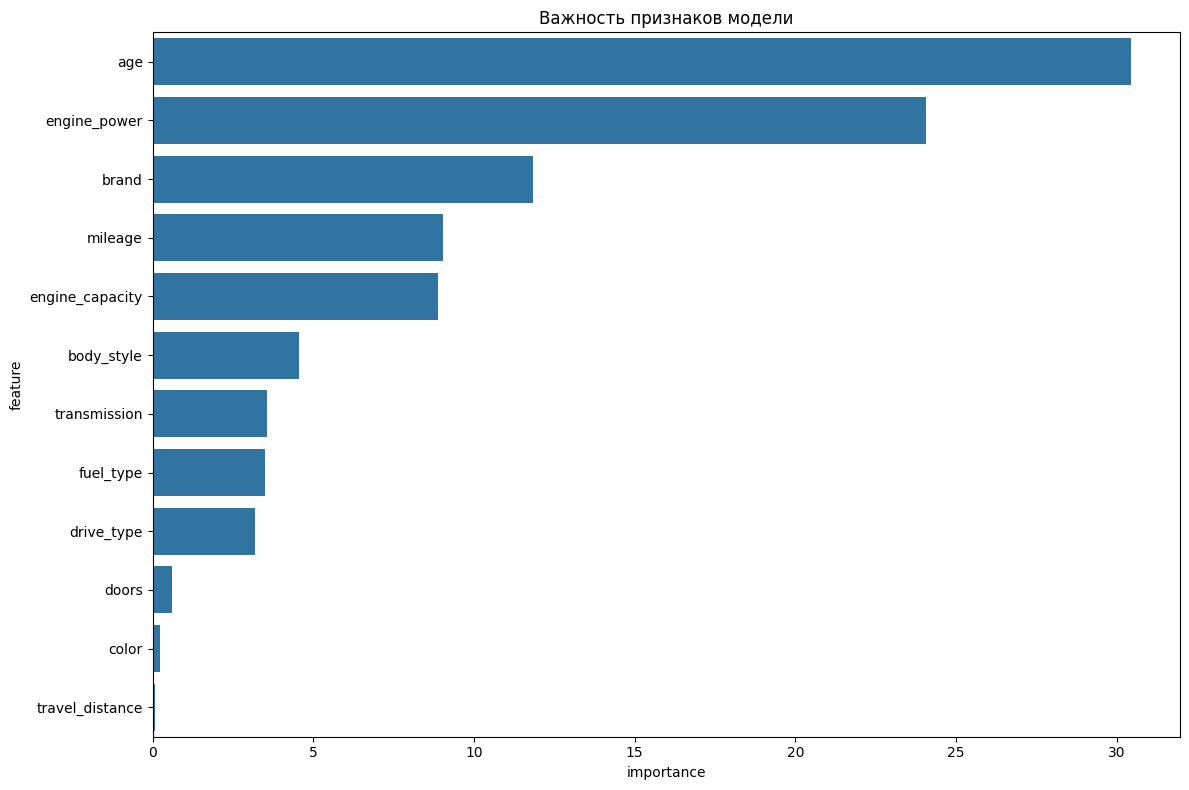

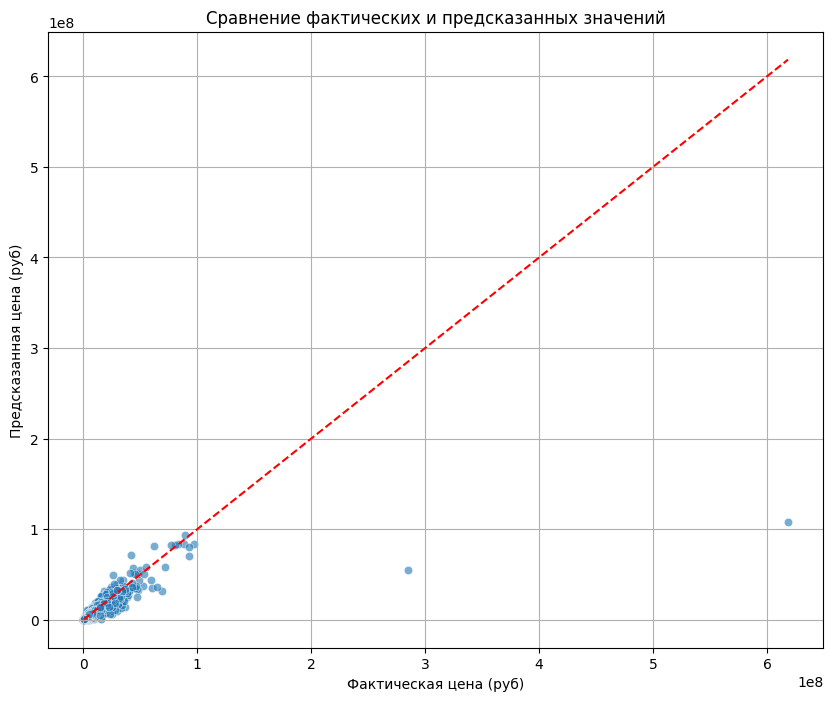

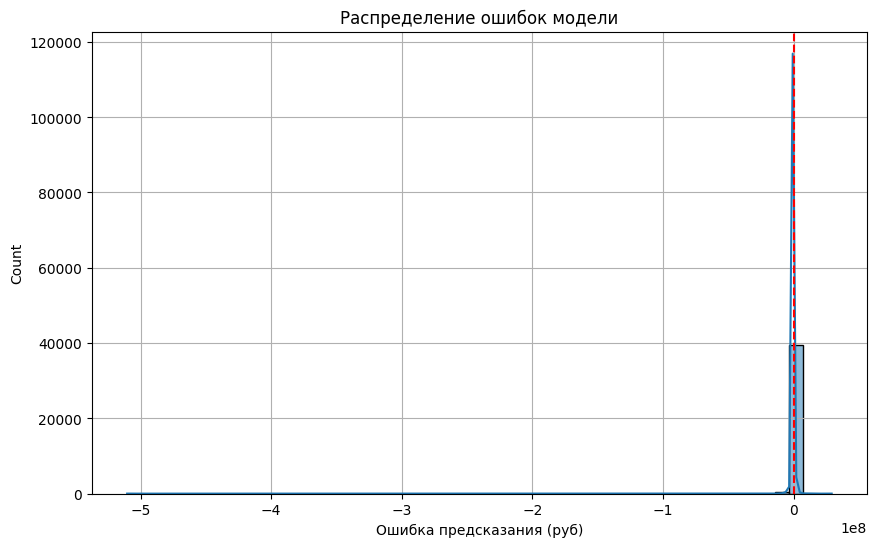


Статистика ошибок по ценовым сегментам:
              mean     median        std
actual                                  
<500к    33.145677  22.398269  38.027030
500к-1м  18.365979  13.953088  17.576053
1-2м     14.187758  10.798339  13.192350
2-5м     14.417944  11.252153  13.385110
>5м      15.908039  12.743452  13.629495


<ipython-input-16-1072482597>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = df_results.groupby(price_bins)['error_percent'].agg(['mean', 'median', 'std'])


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = np.expm1(model.predict(X_test))
y_test_exp = np.expm1(y_test)

metrics = {
    "R²": r2_score(y_test_exp, y_pred),
    "MAE": mean_absolute_error(y_test_exp, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test_exp, y_pred)),
    "MAPE": np.mean(np.abs((y_test_exp - y_pred) / y_test_exp)) * 100
}

print("\n" + "="*50)
print("Оценка точности модели:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}" + ("%" if name == "MAPE" else ""))
print(f"MAE: {metrics['MAE']:.0f} руб.")
print("="*50 + "\n")


feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков модели')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_exp, y=y_pred, alpha=0.6)
plt.plot([y_test_exp.min(), y_test_exp.max()],
         [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel('Фактическая цена (руб)')
plt.ylabel('Предсказанная цена (руб)')
plt.title('Сравнение фактических и предсказанных значений')
plt.grid(True)
plt.show()


errors = y_pred - y_test_exp
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Ошибка предсказания (руб)')
plt.title('Распределение ошибок модели')
plt.grid(True)
plt.show()


df_results = pd.DataFrame({
    'actual': y_test_exp,
    'predicted': y_pred,
    'error': errors,
    'error_percent': np.abs(errors) / y_test_exp * 100
})


price_bins = pd.cut(df_results['actual'],
                    bins=[0, 500000, 1000000, 2000000, 5000000, float('inf')],
                    labels=['<500к', '500к-1м', '1-2м', '2-5м', '>5м'])

error_stats = df_results.groupby(price_bins)['error_percent'].agg(['mean', 'median', 'std'])
print("\nСтатистика ошибок по ценовым сегментам:")
print(error_stats)

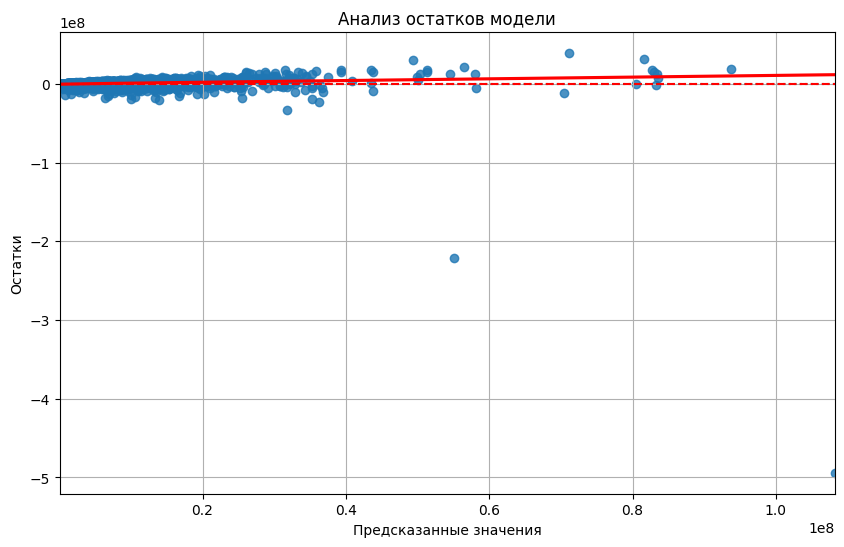


Топ-20 самых больших ошибок:
         actual   predicted  error_percent
13516  220000.0  2352111.26         969.14
47224  500000.0  2760859.04         452.17
31253  200000.0  1079629.19         439.81
21445   50000.0   238997.62         378.00
4124    50000.0   234555.90         369.11
95329   52000.0   243479.58         368.23
9970    65000.0   296756.68         356.55
7292    50000.0   225351.46         350.70
391    520000.0  2288795.32         340.15
88850   70000.0   297530.40         325.04
1450   250000.0  1053151.51         321.26
60670  300000.0  1261338.60         320.45
24319  150000.0   621341.57         314.23
4144    45000.0   183261.31         307.25
1009    65000.0   262187.38         303.37
8275    32000.0   127850.59         299.53
69174   70000.0   279235.52         298.91
30833  100000.0   394766.57         294.77
18542   50000.0   197122.90         294.25
92148   58000.0   224701.34         287.42


In [17]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=errors, lowess=True, line_kws={'color': 'red'})
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков модели')
plt.grid(True)
plt.show()

top_errors = df_results.sort_values('error_percent', ascending=False).head(20)
print("\nТоп-20 самых больших ошибок:")
print(top_errors[['actual', 'predicted', 'error_percent']].round(2))

In [18]:

if col in ['engine_capacity', 'engine_power']:
    df[col] = df[col].replace(0, df[col].median())

In [20]:

for col in cat_cols:
    counts = df[col].value_counts()
    mask = df[col].isin(counts[counts < 10].index)
    df.loc[mask, col] = 'other'

In [21]:

for col in num_cols:
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=q1, upper=q3)

In [22]:

skewed_cols = ['mileage', 'engine_power']
for col in skewed_cols:
    X[col] = np.log1p(X[col])

In [25]:
from catboost import cv
from catboost import Pool


params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': False
}

cv_data = cv(
    pool=Pool(X, y, cat_features=cat_cols + ['brand'] + ['drive_type']),
    params=params,
    fold_count=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2770095261
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2745941225
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2791849906
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2767264901
bestIteration = 999

Training on fold [4/5]

bestTest = 0.2761715094
bestIteration = 999



In [30]:
cat_cols = ['drive_type', 'color', 'fuel_type', 'brand', 'body_style']


for col in cat_cols:
    df[col] = df[col].astype('category')


model = CatBoostRegressor(
    cat_features=cat_cols,
    iterations=1500,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    verbose=200
)


model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)

0:	learn: 1.0936276	test: 1.0926451	best: 1.0926451 (0)	total: 212ms	remaining: 5m 17s
200:	learn: 0.2989391	test: 0.3008756	best: 0.3008756 (200)	total: 25.1s	remaining: 2m 42s
400:	learn: 0.2810039	test: 0.2848537	best: 0.2848537 (400)	total: 51.4s	remaining: 2m 20s
600:	learn: 0.2723885	test: 0.2780647	best: 0.2780647 (600)	total: 1m 17s	remaining: 1m 55s
800:	learn: 0.2670933	test: 0.2741615	best: 0.2741615 (800)	total: 1m 44s	remaining: 1m 31s
1000:	learn: 0.2633315	test: 0.2717355	best: 0.2717355 (1000)	total: 2m 11s	remaining: 1m 5s
1200:	learn: 0.2599707	test: 0.2697851	best: 0.2697851 (1200)	total: 2m 38s	remaining: 39.4s
1400:	learn: 0.2572512	test: 0.2683269	best: 0.2683269 (1400)	total: 3m 5s	remaining: 13.1s
1499:	learn: 0.2560770	test: 0.2677101	best: 0.2677051 (1498)	total: 3m 18s	remaining: 0us

bestTest = 0.2677050851
bestIteration = 1498

Shrink model to first 1499 iterations.
